# Combined Butterfly-Moth and Euro-Coin Classifier


## Check if the GPU is being used

In [2]:
import tensorflow as tf

# Verifica si TensorFlow tiene acceso a la GPU
physical_devices = tf.config.list_physical_devices('GPU')

if len(physical_devices) > 0:
    print(f"Keras/TensorFlow tiene acceso a la GPU -> {tf.test.gpu_device_name()}")
else:
    print("Keras/TensorFlow está utilizando la CPU.")


Keras/TensorFlow tiene acceso a la GPU -> /device:GPU:0


## Required imports and previous configuration

In [3]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.utils import to_categorical
import matplotlib.pyplot as plt
import random
import numpy as np
import tensorflow as tf
import os

# Establecer una semilla para reproducibilidad
seed_value = 42
random.seed(seed_value)        # Semilla para Python
np.random.seed(seed_value)     # Semilla para NumPy
tf.random.set_seed(seed_value) # Semilla para TensorFlow/Keras

## Data augmentation with generator

In [4]:
import os
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras_preprocessing.image import load_img, img_to_array

'''
image_size = (200, 200) 
batch_size = 16

# Configuración del generador de aumento de datos
data_augmentation = ImageDataGenerator(
    rescale=1./255,                 # Normalización de los valores de píxeles
    rotation_range=40,              # Grados de rotación aleatoria
    width_shift_range=0.1,          # Desplazamiento horizontal aleatorio
    height_shift_range=0.1,         # Desplazamiento vertical aleatorio
    shear_range=0.1,                # Cizalla aleatoria
    zoom_range=0.1,                 # Rango de zoom aleatorio
    channel_shift_range=5,         # Cambios aleatorios en los canales de colores
    brightness_range=[0.8,1.2],     # Rango de brillo aleatorio
    horizontal_flip=True,           # Activar volteo horizontal
    vertical_flip=True,             # Activar volteo vertical
    fill_mode='nearest'             # Modo de llenado para cuando se aplican transformaciones espaciales
)

# Directorio con las imagenese originales
source_dir = '../datasets/coins_final/all'

# Directorio de salida para las imágenes aumentadas
augmented_dir = '../datasets/coins_final/augmented_all'

# Función para guardar las imágenes aumentadas
def save_augmented_images(directory, augmented_directory, generator, num_images_per_file=5):
    # Crear el directorio si no existe
    if not os.path.exists(augmented_directory):
        os.makedirs(augmented_directory)
    
    for subdir in os.listdir(directory):
        subdirectory = os.path.join(directory, subdir)
        if os.path.isdir(subdirectory):
            augmented_subdir = os.path.join(augmented_directory, subdir)
            if not os.path.exists(augmented_subdir):
                os.makedirs(augmented_subdir)
            
            for file in os.listdir(subdirectory):
                file_path = os.path.join(subdirectory, file)
                image_obj = load_img(file_path)
                image_array = img_to_array(image_obj)
                image_array = image_array.reshape((1,) + image_array.shape)
                
                # Generar nuevas imágenes
                i = 0
                for batch in generator.flow(image_array, batch_size=1, save_to_dir=augmented_subdir, save_prefix=subdir, save_format='png'):
                    i += 1
                    if i >= num_images_per_file:
                        break  # Guardar 5 imágenes y luego continuar con la siguiente imagen

# Aplicar aumento de datos al conjunto de entrenamiento y validación
save_augmented_images(source_dir, augmented_dir, data_augmentation)

'''

"\nimage_size = (200, 200) \nbatch_size = 16\n\n# Configuración del generador de aumento de datos\ndata_augmentation = ImageDataGenerator(\n    rescale=1./255,                 # Normalización de los valores de píxeles\n    rotation_range=40,              # Grados de rotación aleatoria\n    width_shift_range=0.1,          # Desplazamiento horizontal aleatorio\n    height_shift_range=0.1,         # Desplazamiento vertical aleatorio\n    shear_range=0.1,                # Cizalla aleatoria\n    zoom_range=0.1,                 # Rango de zoom aleatorio\n    channel_shift_range=5,         # Cambios aleatorios en los canales de colores\n    brightness_range=[0.8,1.2],     # Rango de brillo aleatorio\n    horizontal_flip=True,           # Activar volteo horizontal\n    vertical_flip=True,             # Activar volteo vertical\n    fill_mode='nearest'             # Modo de llenado para cuando se aplican transformaciones espaciales\n)\n\n# Directorio con las imagenese originales\nsource_dir = '.

In [5]:
# DATA SOURCE --------------------------------------------------
# '''
image_size = (200, 200) 
batch_size = 64
data_dir = os.path.join('../datasets/ButterflyMothsAndCoins')

train_dir = os.path.join('../datasets/ButterflyMothsAndCoins/redistributed_all/train') 
valid_dir = os.path.join('../datasets/ButterflyMothsAndCoins/redistributed_all/valid') 
test_dir = os.path.join('../datasets/ButterflyMothsAndCoins/redistributed_all/test') 

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=train_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=valid_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    directory=test_dir,
    image_size=image_size,
    batch_size=batch_size,
    label_mode='categorical'
)

train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)
test_ds = test_ds.prefetch(buffer_size=32)
# '''

Found 12889 files belonging to 16 classes.
Found 3685 files belonging to 16 classes.
Found 1851 files belonging to 16 classes.


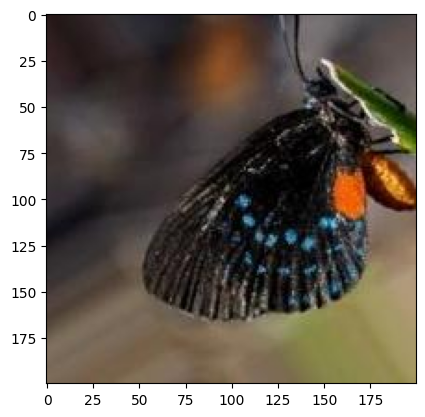

In [6]:
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image

%matplotlib inline

pil_im = Image.open('../datasets/ButterflyMothsAndCoins/redistributed_all/train/ATALA/ATALA_0_1034.jpeg', 'r')
imshow(np.asarray(pil_im))

## Model definition and configuration 

In [6]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Rescaling, Flatten
from keras.callbacks import EarlyStopping

model = keras.Sequential()

model.add(Rescaling(scale=1./255.0,
                    offset=-1,
                    input_shape=(200,200,3)))

model.add(Conv2D(32, kernel_size=(5, 5), activation='relu', strides=(1, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(5, 5), activation='relu', strides=(1, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', strides=(1, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', strides=(1, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu', strides=(1, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.45))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(16, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(1e-3),
              metrics=['accuracy'])


## Training

In [7]:
epochs = 100

es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=10, restore_best_weights=True)

h = model.fit(
        train_ds, # train_gen, 
        epochs=epochs,
        validation_data=val_ds,
        callbacks = [es],
        # steps_per_epoch=200 # (steps_per_epoch = total_samples / batch_size)
)

# model = tf.keras.models.load_model('trained_models/coins_model.h5') # Load the model
model.save('trained_models/butterfly_and_coins_model.h5')  # Save as HDF5 file

Epoch 1/100


202/202 [==============================] - 27s 107ms/step - loss: 1.8451 - accuracy: 0.3761 - val_loss: 1.0723 - val_accuracy: 0.6404
Epoch 2/100
202/202 [==============================] - 20s 96ms/step - loss: 0.9141 - accuracy: 0.6886 - val_loss: 0.7150 - val_accuracy: 0.7474
Epoch 3/100
202/202 [==============================] - 19s 96ms/step - loss: 0.6919 - accuracy: 0.7595 - val_loss: 0.6172 - val_accuracy: 0.7856
Epoch 4/100
202/202 [==============================] - 19s 96ms/step - loss: 0.5527 - accuracy: 0.8053 - val_loss: 0.4293 - val_accuracy: 0.8475
Epoch 5/100
202/202 [==============================] - 19s 96ms/step - loss: 0.4500 - accuracy: 0.8411 - val_loss: 0.3443 - val_accuracy: 0.8706
Epoch 6/100
202/202 [==============================] - 19s 96ms/step - loss: 0.3879 - accuracy: 0.8620 - val_loss: 0.3891 - val_accuracy: 0.8613
Epoch 7/100
202/202 [==============================] - 20s 96ms/step - loss: 0.3489 - accuracy: 0.8738 - val_loss: 0.2475 - val_accuracy: 0.9

## Graphical representation of results

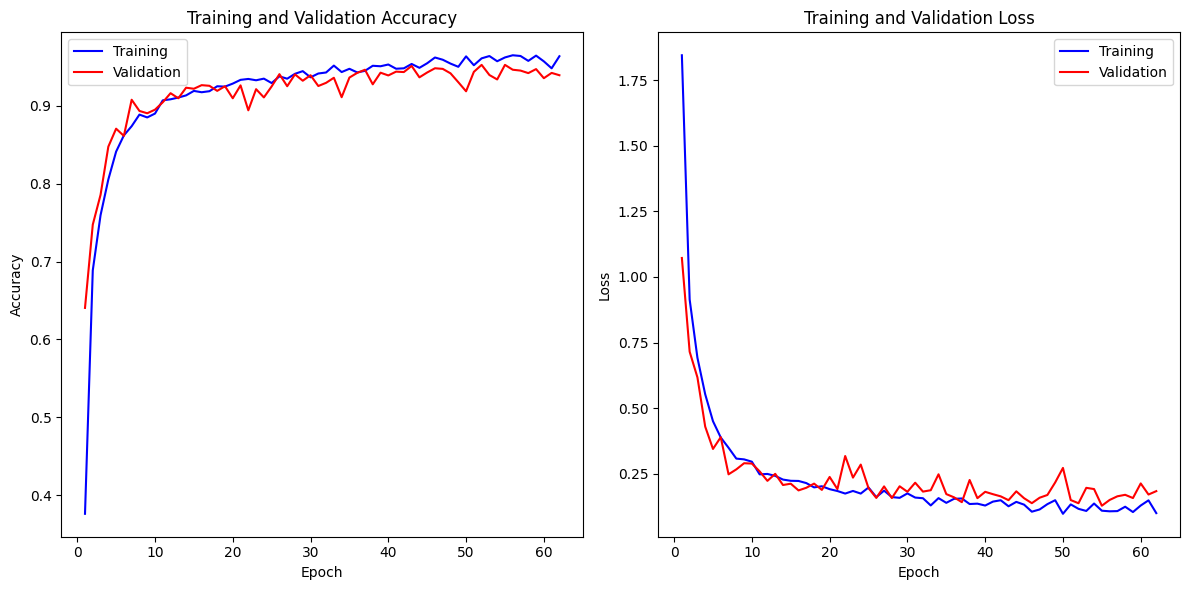

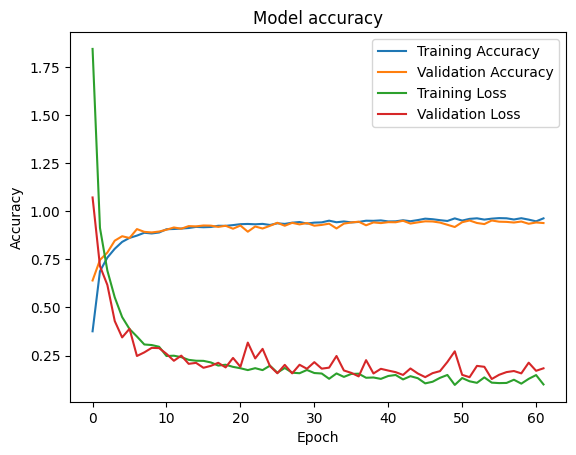

In [8]:
import matplotlib.pyplot as plt

def separate_plot(h):
    # Extracción de datos
    acc = h.history['accuracy']
    val_acc = h.history['val_accuracy']
    loss = h.history['loss']
    val_loss = h.history['val_loss']
    epochs = range(1, len(acc) + 1)

    # Creación del gráfico de accuracy
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'b', label='Training')
    plt.plot(epochs, val_acc, 'r', label='Validation')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Creación del gráfico de loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'b', label='Training')
    plt.plot(epochs, val_loss, 'r', label='Validation')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
def combined_plot(h):
    plt.plot(h.history['accuracy'])
    plt.plot(h.history['val_accuracy'])
    plt.plot(h.history['loss'])
    plt.plot(h.history['val_loss'])
    plt.title('Model accuracy')    
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Training Accuracy', 'Validation Accuracy','Training Loss','Validation Loss'], loc='upper right')
    plt.show()

#------------------------------------------------------------------------
# Generate separate results plot
separate_plot(h)

# Generate combined results plot
combined_plot(h)

## Evaluation of results

Found 1851 files belonging to 16 classes.
2/2 [==============================] - 0s 402ms/step


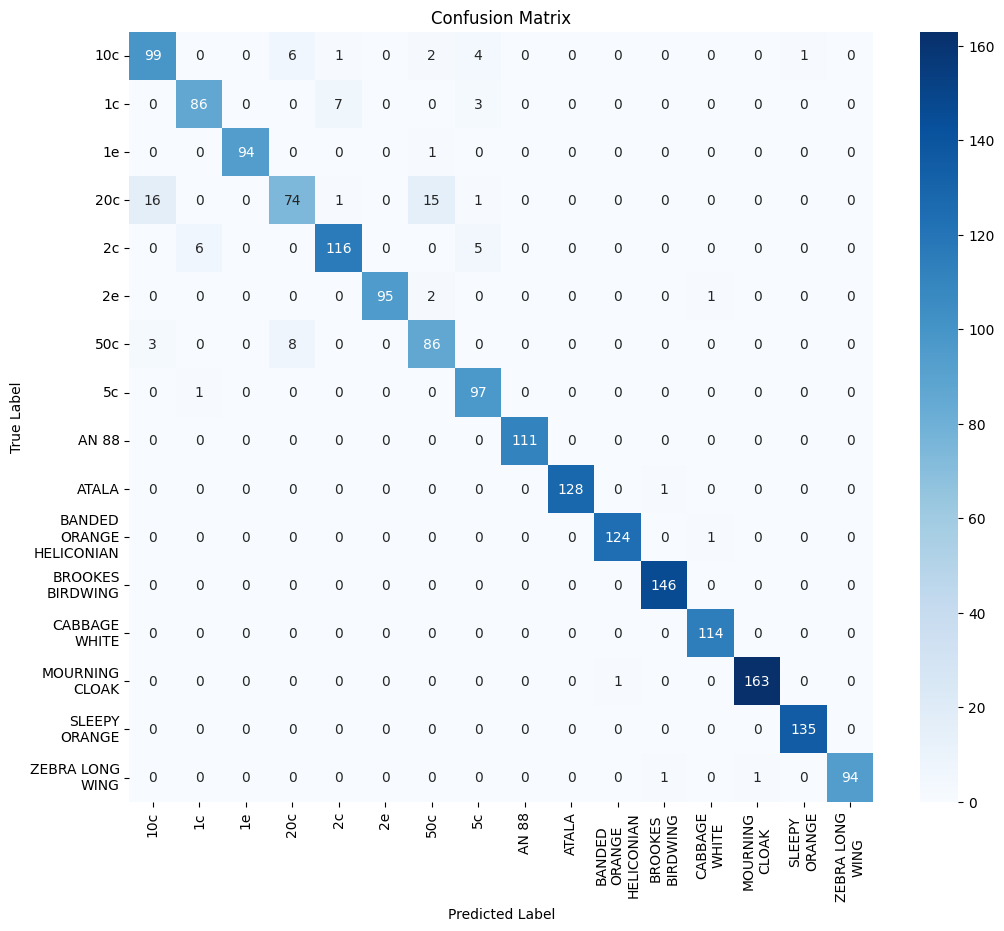

                          precision    recall  f1-score   support

                     10c     0.8390    0.8761    0.8571       113
                      1c     0.9247    0.8958    0.9101        96
                      1e     1.0000    0.9895    0.9947        95
                     20c     0.8409    0.6916    0.7590       107
                      2c     0.9280    0.9134    0.9206       127
                      2e     1.0000    0.9694    0.9845        98
                     50c     0.8113    0.8866    0.8473        97
                      5c     0.8818    0.9898    0.9327        98
                   AN 88     1.0000    1.0000    1.0000       111
                   ATALA     1.0000    0.9922    0.9961       129
BANDED
ORANGE
HELICONIAN     0.9920    0.9920    0.9920       125
        BROOKES
BIRDWING     0.9865    1.0000    0.9932       146
           CABBAGE
WHITE     0.9828    1.0000    0.9913       114
          MOURNING
CLOAK     0.9939    0.9939    0.9939       164
         

In [9]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing import image_dataset_from_directory

def split_labels(labels, max_length):
    """
    Format long labels by adding line breaks.

    Args:
    labels (list of str): Original list of labels.
    max_length (int): Maximum line length in a label.

    Returns:
    list of str: Labels with line breaks added.
    """
    formatted_labels = []
    for label in labels:
        if len(label) <= max_length:
            formatted_labels.append(label)
            continue

        # Split label into words and construct new label with line breaks
        words = label.split()
        new_label = words[0]
        for word in words[1:]:
            if len(new_label + ' ' + word) <= max_length:
                new_label += ' ' + word
            else:
                new_label += '\n' + word
        formatted_labels.append(new_label)
    
    return formatted_labels


def evaluate_model(test_dir, model, test_ds, max_label_length=15):
    """
    Function to evaluate a model with a validation dataset.
    Displays the confusion matrix and classification report.

    Args:
    test_dir (str): Test dataset directory to load class names
    model (keras.Model): Model to evaluate.
    test_ds (tf.data.Dataset): Test dataset.
    max_label_length (int): Maximum allowed label length before splitting at word boundaries.
    """
    # Load class names and plit long labels at word boundaries
    class_names = split_labels(labels=image_dataset_from_directory(directory=test_dir).class_names,
                               max_length= max_label_length)
    
    # Generate predictions and true labels
    results = np.concatenate([(y.numpy(), model.predict(x)) for x, y in test_ds], axis=1)
    predictions = np.argmax(results[1], axis=1)
    labels = np.argmax(results[0], axis=1)

    # Calculate the confusion matrix with formatted labels
    cf_matrix = confusion_matrix(labels, predictions)

    # Create a heatmap for the confusion matrix with formatted labels
    plt.figure(figsize=(12, 10))
    sns.heatmap(cf_matrix, annot=True, fmt="d", cmap="Blues",
                          xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    # Display the classification report with formatted labels
    formatted_labels = split_labels(class_names, max_label_length)
    formatted_classification_report = classification_report(labels, predictions, target_names=formatted_labels, digits=4)
    print(formatted_classification_report)

model = tf.keras.models.load_model('trained_models/butterfly_and_coins_model.h5') # Load the model
# Example usage:
evaluate_model(test_dir, model, test_ds, max_label_length=11)


# VGG16 (Visual Geometry Group) CNN-Net

## Model configuration and training

**Explanation of "Inference Mode"**

When it's said that the "base model is in inference mode," it means that the model is being used for making predictions (inferences) rather than for training. This is important when using a pretrained model and only wanting to fine-tune the last layers without modifying the previously learned weights in the earlier layers.

In TensorFlow and Keras, this is achieved by setting `training=False` when calling the base model. This way, the model won't update its weights during the backpropagation process, preserving the previously learned weights.

**Other Modes:**

1. **Training Mode**: This is when `training=True`. In this mode, all training-related operations, such as gradient computation and weight updates, are active.

2. **Inference Mode**: `training=False` indicates that the model is being used to make predictions. Training-specific operations like dropout or batch normalization layers behave differently in this mode to reflect that the model is not being trained.

Using the correct mode is crucial for achieving the expected results, especially when working with pretrained models and performing fine-tuning.

In [6]:
from tensorflow.keras.applications import VGG16
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

# Load the VGG16 model pre-trained on ImageNet data
base_model = VGG16(
    weights='imagenet', 
    input_shape=(200, 200, 3),
    include_top=False)  # Exclude the top (fully connected) layers

# Set the VGG16 model to be non-trainable to retain the pre-trained weights
base_model.trainable = False

# Define the input layer
input_layer = keras.Input(shape=(200, 200, 3))

# Use the base model as a feature extractor
# Ensure the base_model runs in inference mode, important for fine-tuning, as
feature_vector = base_model(input_layer, training=False)

# Add GlobalAveragePooling2D layer to reduce feature map size
global_avg_pooling = keras.layers.GlobalAveragePooling2D()(feature_vector)

# Add Dense layer to interpret the features
dense_layer = keras.layers.Dense(256, activation='relu')(global_avg_pooling)

# Output layer for classification into 8 classes
output_layer = keras.layers.Dense(16, activation='softmax')(dense_layer)

# Create the final model
model_with_VGG16 = keras.Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model_with_VGG16.compile(loss='categorical_crossentropy',
                         optimizer=keras.optimizers.Adam(1e-3),
                         metrics=['accuracy'])

# Set the number of epochs for training
epochs = 50

# Early stopping to monitor the validation accuracy and stop training when it starts to decrease
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5, restore_best_weights=True)

# Train the model with the training and validation data
h_vgg16 = model_with_VGG16.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[es]
)

# Save the trained model
model_with_VGG16.save('trained_models/butterfly_and_coins_model_with_VGG16.h5')  # Save as HDF5 file


Epoch 1/50
202/202 [==============================] - 68s 277ms/step - loss: 0.7250 - accuracy: 0.8177 - val_loss: 0.2427 - val_accuracy: 0.9175
Epoch 2/50
202/202 [==============================] - 50s 245ms/step - loss: 0.1543 - accuracy: 0.9494 - val_loss: 0.1836 - val_accuracy: 0.9400
Epoch 3/50
202/202 [==============================] - 49s 241ms/step - loss: 0.1041 - accuracy: 0.9662 - val_loss: 0.1402 - val_accuracy: 0.9531
Epoch 4/50
202/202 [==============================] - 48s 235ms/step - loss: 0.0703 - accuracy: 0.9763 - val_loss: 0.1332 - val_accuracy: 0.9566
Epoch 5/50
202/202 [==============================] - 48s 235ms/step - loss: 0.0471 - accuracy: 0.9854 - val_loss: 0.1092 - val_accuracy: 0.9620
Epoch 6/50
202/202 [==============================] - 52s 257ms/step - loss: 0.0376 - accuracy: 0.9891 - val_loss: 0.0985 - val_accuracy: 0.9658
Epoch 7/50
202/202 [==============================] - 49s 243ms/step - loss: 0.0256 - accuracy: 0.9933 - val_loss: 0.1022 - val_ac

## Graphical representation of results

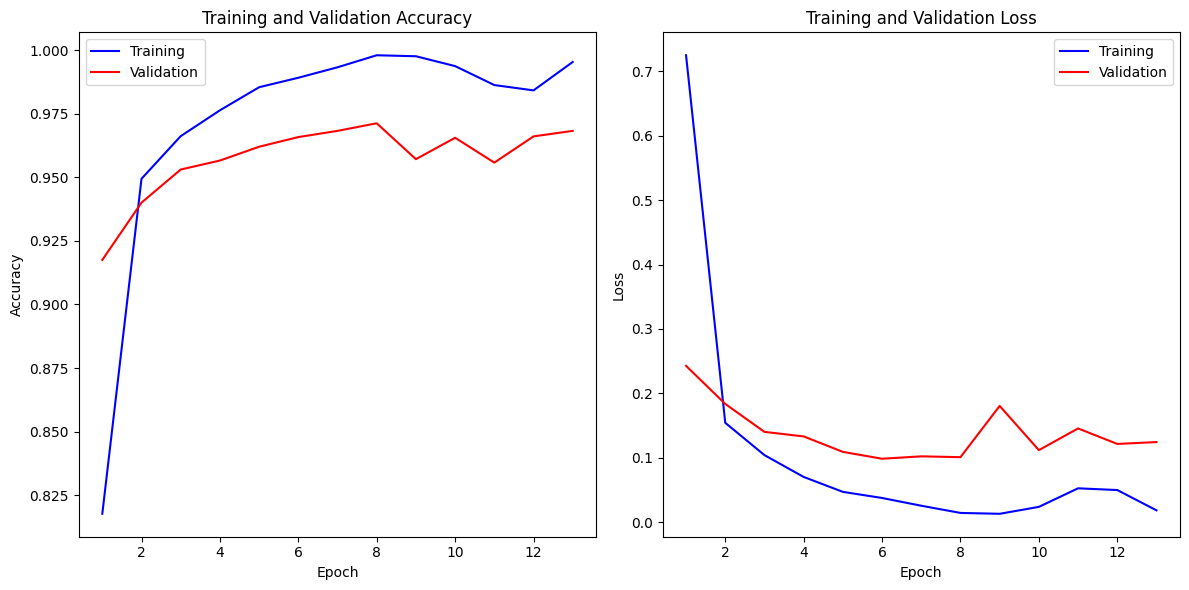

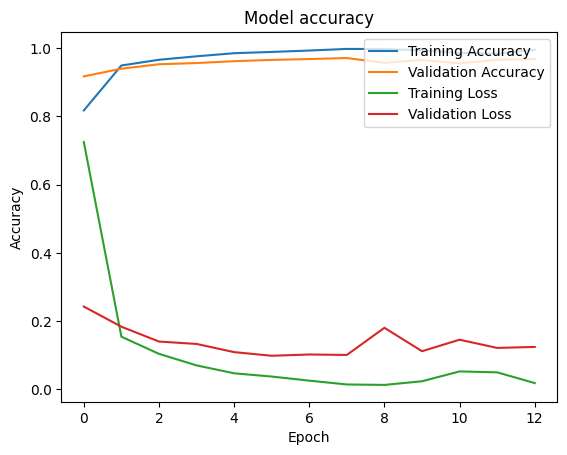

In [9]:
#------------------------------------------------------------------------

# Generate separate results plot
separate_plot(h_vgg16)

# Generate combined results plot
combined_plot(h_vgg16)

## Evaluation of results

Found 1851 files belonging to 16 classes.
2/2 [==============================] - 3s 3s/step


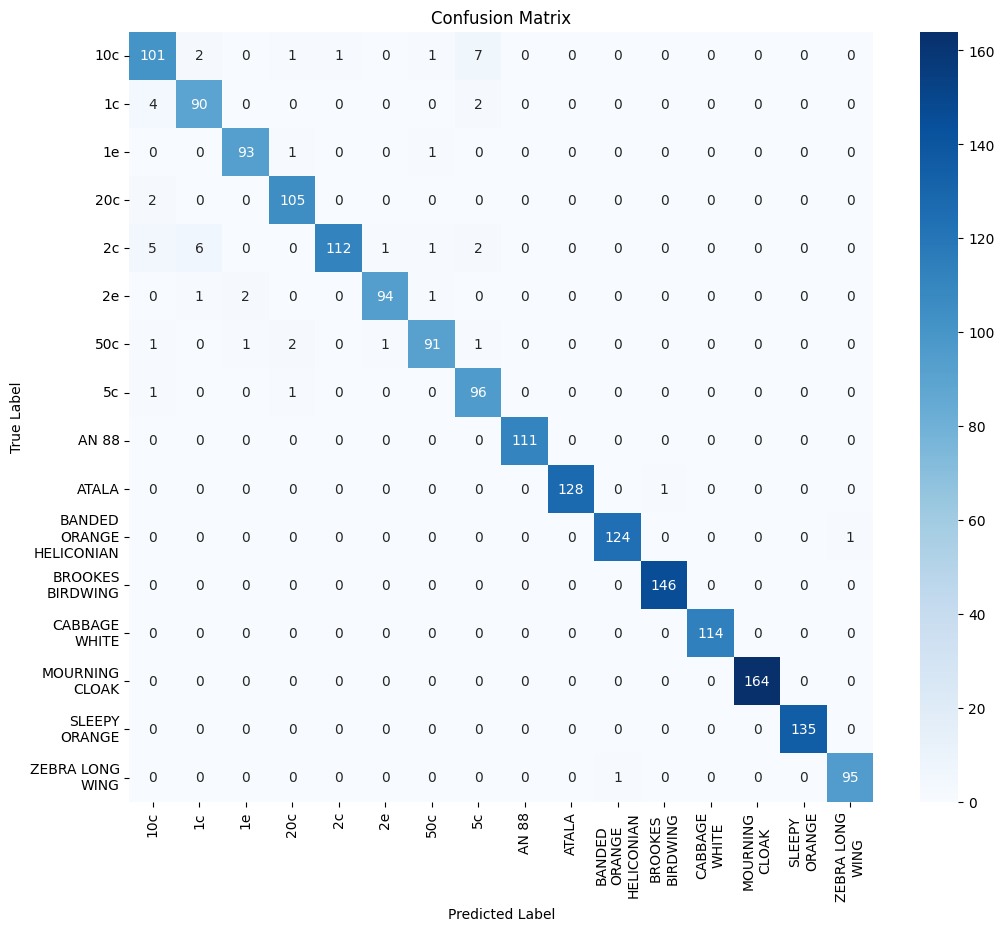

                          precision    recall  f1-score   support

                     10c     0.8860    0.8938    0.8899       113
                      1c     0.9091    0.9375    0.9231        96
                      1e     0.9688    0.9789    0.9738        95
                     20c     0.9545    0.9813    0.9677       107
                      2c     0.9912    0.8819    0.9333       127
                      2e     0.9792    0.9592    0.9691        98
                     50c     0.9579    0.9381    0.9479        97
                      5c     0.8889    0.9796    0.9320        98
                   AN 88     1.0000    1.0000    1.0000       111
                   ATALA     1.0000    0.9922    0.9961       129
BANDED
ORANGE
HELICONIAN     0.9920    0.9920    0.9920       125
        BROOKES
BIRDWING     0.9932    1.0000    0.9966       146
           CABBAGE
WHITE     1.0000    1.0000    1.0000       114
          MOURNING
CLOAK     1.0000    1.0000    1.0000       164
         

In [17]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Call to evaluate model function -> Confusion matrix and classification report
evaluate_model(test_dir, model_with_VGG16, test_ds, max_label_length=11)


# VGG19 (Visual Geometry Group) CNN-Net

## Model configuration and training

In [18]:
from tensorflow.keras.applications import VGG19
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

# Load the VGG19 model pre-trained on ImageNet data
base_model = VGG19(
    weights='imagenet',
    input_shape=(200, 200, 3),
    include_top=False)  # Exclude the top (fully connected) layers

# Set the VGG19 model to be non-trainable to retain the pre-trained weights
base_model.trainable = False

# Define the input layer
input_layer = keras.Input(shape=(200, 200, 3))

# Use the base model as a feature extractor
# Ensure the base_model runs in inference mode, important for fine-tuning
feature_vector = base_model(input_layer, training=False)

# Add GlobalAveragePooling2D layer to reduce feature map size
global_avg_pooling = keras.layers.GlobalAveragePooling2D()(feature_vector)

# Add Dense layer to interpret the features
dense_layer = keras.layers.Dense(256, activation='relu')(global_avg_pooling)

# Output layer for classification into 16 classes
output_layer = keras.layers.Dense(16, activation='softmax')(dense_layer)

# Create the final model
model_with_VGG19 = keras.Model(inputs=input_layer, outputs=output_layer)
model_with_VGG19.compile(loss='categorical_crossentropy',
                         optimizer=keras.optimizers.Adam(1e-3),
                         metrics=['accuracy'])

# Set the number of epochs for training
epochs = 50

# Early stopping to monitor the validation accuracy and stop training when it starts to decrease
es = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=5, restore_best_weights=True)

# Train the model with the training and validation data
h_vgg19 = model_with_VGG19.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[es]
)

model_with_VGG19.save('trained_models/butterfly_and_coins_model_with_VGG19.h5')  # Save as HDF5 file


Epoch 1/50
202/202 [==============================] - 67s 328ms/step - loss: 0.6920 - accuracy: 0.8087 - val_loss: 0.2946 - val_accuracy: 0.8969
Epoch 2/50
202/202 [==============================] - 60s 296ms/step - loss: 0.1948 - accuracy: 0.9305 - val_loss: 0.1992 - val_accuracy: 0.9305
Epoch 3/50
202/202 [==============================] - 59s 293ms/step - loss: 0.1267 - accuracy: 0.9570 - val_loss: 0.1540 - val_accuracy: 0.9471
Epoch 4/50
202/202 [==============================] - 58s 288ms/step - loss: 0.0868 - accuracy: 0.9696 - val_loss: 0.1473 - val_accuracy: 0.9490
Epoch 5/50
202/202 [==============================] - 59s 290ms/step - loss: 0.0731 - accuracy: 0.9746 - val_loss: 0.1484 - val_accuracy: 0.9484
Epoch 6/50
202/202 [==============================] - 57s 283ms/step - loss: 0.0457 - accuracy: 0.9854 - val_loss: 0.1166 - val_accuracy: 0.9601
Epoch 7/50
202/202 [==============================] - 59s 290ms/step - loss: 0.0348 - accuracy: 0.9895 - val_loss: 0.1199 - val_ac

## Graphical representation of results

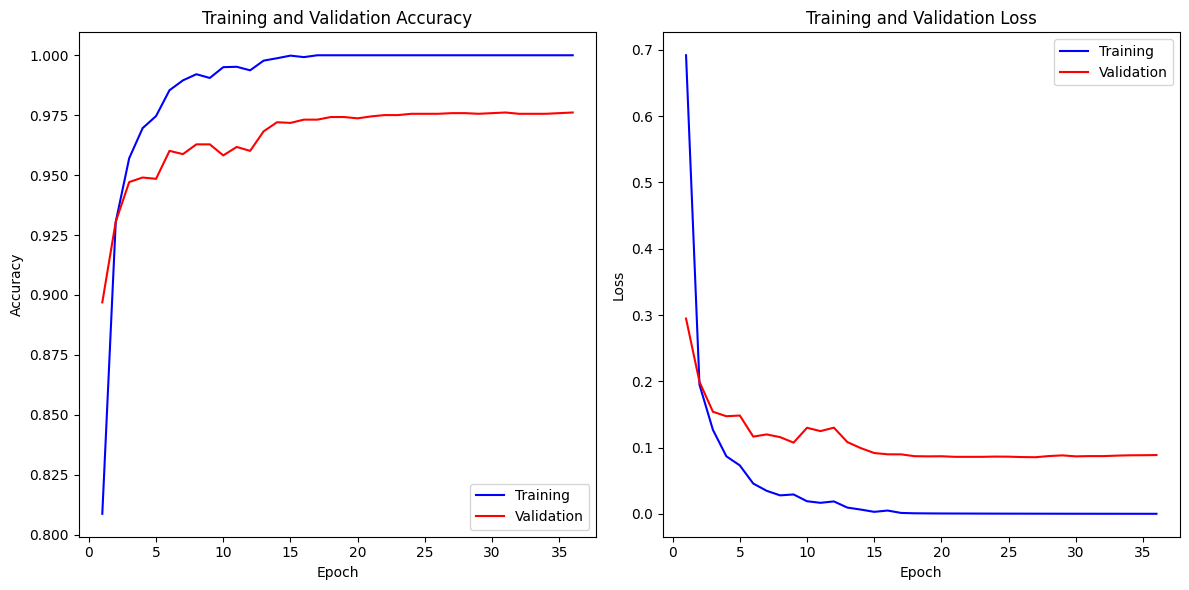

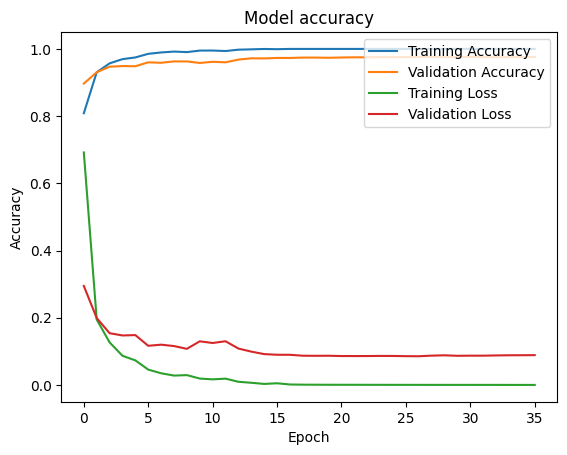

In [19]:
#------------------------------------------------------------------------
# Generate separate results plot
separate_plot(h_vgg19)

# Generate combined results plot
combined_plot(h_vgg19)

## Evaluation of results

Found 1851 files belonging to 16 classes.
2/2 [==============================] - 0s 150ms/step


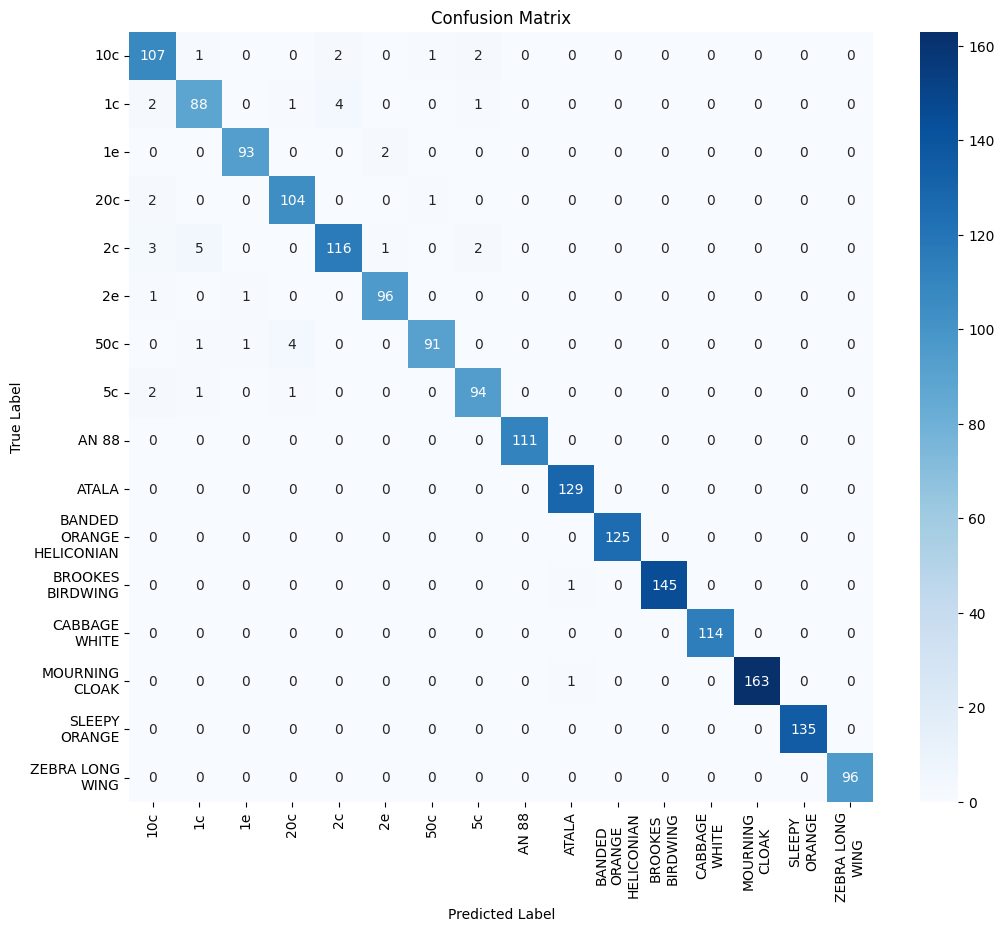

                          precision    recall  f1-score   support

                     10c     0.9145    0.9469    0.9304       113
                      1c     0.9167    0.9167    0.9167        96
                      1e     0.9789    0.9789    0.9789        95
                     20c     0.9455    0.9720    0.9585       107
                      2c     0.9508    0.9134    0.9317       127
                      2e     0.9697    0.9796    0.9746        98
                     50c     0.9785    0.9381    0.9579        97
                      5c     0.9495    0.9592    0.9543        98
                   AN 88     1.0000    1.0000    1.0000       111
                   ATALA     0.9847    1.0000    0.9923       129
BANDED
ORANGE
HELICONIAN     1.0000    1.0000    1.0000       125
        BROOKES
BIRDWING     1.0000    0.9932    0.9966       146
           CABBAGE
WHITE     1.0000    1.0000    1.0000       114
          MOURNING
CLOAK     1.0000    0.9939    0.9969       164
         

In [20]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Call to evaluate model function -> Confusion matrix and classification report
evaluate_model(test_dir, model_with_VGG19, test_ds, max_label_length=11)


# ResNet50 (Residual Neural Network) CNN-Net

## Model configuration and training

In [7]:
from tensorflow.keras.applications import ResNet50
from tensorflow import keras
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Load the ResNet50 model pre-trained on ImageNet data
base_model = ResNet50(
    weights='imagenet',
    input_shape=(200, 200, 3),
    include_top=False)  # Exclude the top (fully connected) layers

# Set the ResNet50 model to be non-trainable to retain the pre-trained weights
base_model.trainable = False

# Define the input layer
input_layer = Input(shape=(200, 200, 3))

# Use the base model as a feature extractor: Setting training=False ensures that it operates in inference mode.
feature_vector = base_model(input_layer, training=False)

# Add GlobalAveragePooling2D layer to reduce feature map size
pooled_features = GlobalAveragePooling2D()(feature_vector)

# Add Dense layer to interpret the features
dense_layer = Dense(256, activation='relu')(pooled_features)

# Output layer for classification into 8 classes
output_layer = Dense(16, activation='softmax')(dense_layer)

# Create the final model
model_with_resnet50 = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
model_with_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(1e-3),
    metrics=['accuracy'])

# Set the number of epochs for training
epochs = 50

# Early stopping to monitor the validation accuracy and stop training when it starts to decrease
es_callback = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=3, restore_best_weights=True)

# Train the model with the training and validation data
history_resnet50 = model_with_resnet50.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds,
    callbacks=[es_callback]
)

model_with_resnet50.save('trained_models/butterfly_and_coins_model_with_resnet50.h5')  # Save as HDF5 file


Epoch 1/50
202/202 [==============================] - 35s 142ms/step - loss: 0.3610 - accuracy: 0.8766 - val_loss: 0.1736 - val_accuracy: 0.9384
Epoch 2/50
202/202 [==============================] - 28s 137ms/step - loss: 0.1182 - accuracy: 0.9604 - val_loss: 0.1207 - val_accuracy: 0.9620
Epoch 3/50
202/202 [==============================] - 28s 137ms/step - loss: 0.0772 - accuracy: 0.9738 - val_loss: 0.1130 - val_accuracy: 0.9626
Epoch 4/50
202/202 [==============================] - 28s 137ms/step - loss: 0.0599 - accuracy: 0.9806 - val_loss: 0.0841 - val_accuracy: 0.9699
Epoch 5/50
202/202 [==============================] - 28s 137ms/step - loss: 0.0391 - accuracy: 0.9885 - val_loss: 0.0912 - val_accuracy: 0.9701
Epoch 6/50
202/202 [==============================] - 28s 137ms/step - loss: 0.0318 - accuracy: 0.9912 - val_loss: 0.0625 - val_accuracy: 0.9780
Epoch 7/50
202/202 [==============================] - 28s 137ms/step - loss: 0.0189 - accuracy: 0.9957 - val_loss: 0.0703 - val_ac

## Graphical representation of results

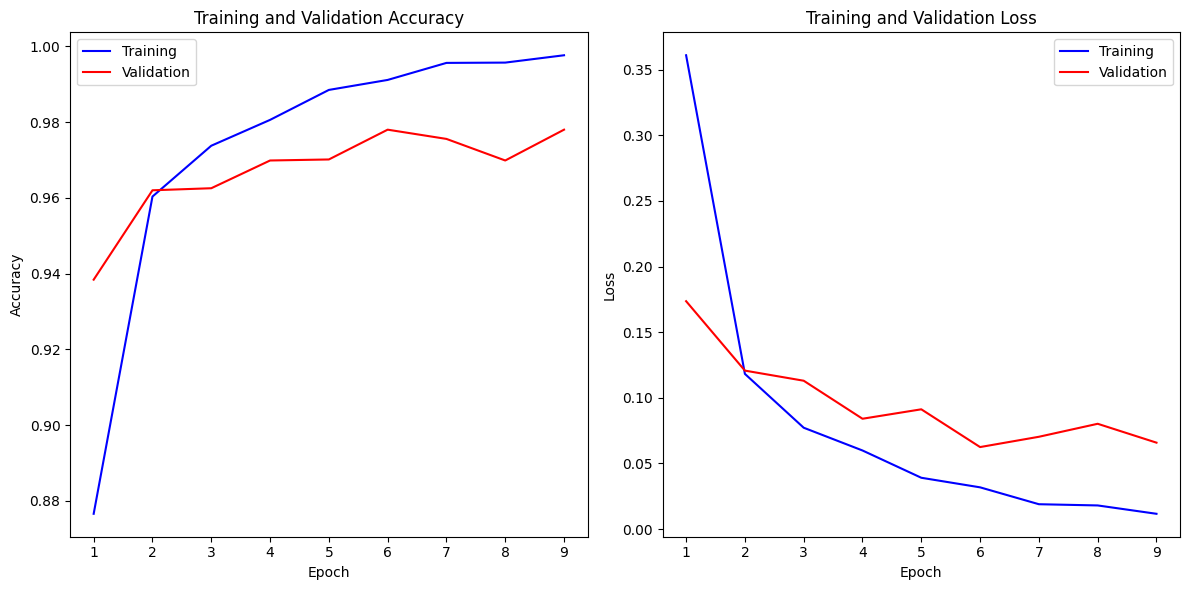

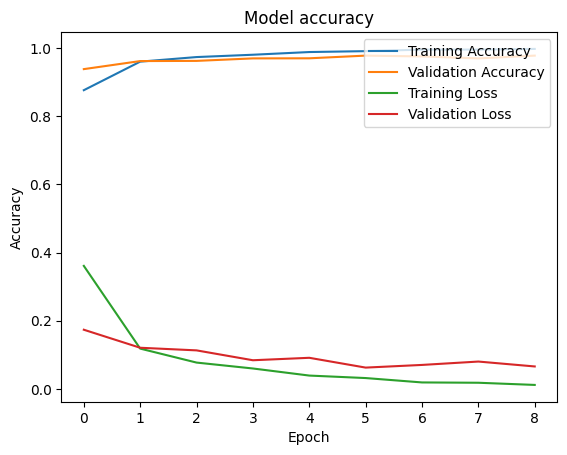

In [10]:
#------------------------------------------------------------------------
# Generate separate results plot
separate_plot(history_resnet50)

# Generate combined results plot
combined_plot(history_resnet50)

## Evaluation of results

In [12]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


# Call to evaluate model function -> Confusion matrix and classification report
evaluate_model(test_dir, model_with_resnet50, test_ds, max_label_length=11)


Found 1851 files belonging to 16 classes.
2/2 [==============================] - 0s 57ms/step
